In [1]:
import os
from PIL import Image

Se pasa de la imagen descargada de internet a la dimension que se requiere para el dataset

In [46]:
# Recortar las imagenes de un directorio y guardarlas en otro directorio recortadas

# Define el directorio de entrada y salida
input_directory = '/home/mccdual2080/Desktop/SahirReyes/ActualizacionMapas'
output_directory = '/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF'

# Lista de nombres de archivos de imágenes en el directorio de entrada
image_files = os.listdir(input_directory)

for filename in image_files:
    # Verifica si el archivo tiene la extensión de imagen deseada (por ejemplo, '.jpg' o '.png')
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Abre la imagen
        full_input_path = os.path.join(input_directory, filename)
        img = Image.open(full_input_path)

        print(f"Imagen abierta: {full_input_path}")


        # Define la región de recorte
        crop_rectangle = (240, 318, 600, 440) #122*360
        #crop_rectangle = (240, 318, 600, 438) #120*360
        #crop_rectangle = (0, 1, 360, 121)  # (izquierda, superior, derecha, inferior) pasar de 122 a 120 
        img_cropped = img.crop(crop_rectangle)

        # Construye la ruta de salida con el mismo nombre de archivo
        full_output_path = os.path.join(output_directory, filename)

        # Guarda la imagen recortada en la nueva ubicación
        img_cropped.save(full_output_path)

        print(f"Imagen guardada: {full_output_path}")


Imagen abierta: /home/mccdual2080/Desktop/SahirReyes/ActualizacionMapas/2024-01-09.png
Imagen guardada: /home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2024-01-09.png


Agregar la mascara para añadir la categoria numero siete 

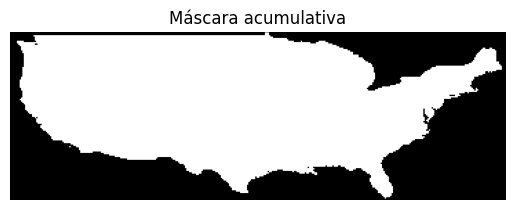

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Ruta al directorio con tus imágenes
dir_path = '/home/mccdual2080/Desktop/SahirReyes/Codigo/DroughtDatasetCleaned'

# Carga la primera imagen del dataset para obtener sus dimensiones
first_image_name = os.listdir(dir_path)[0]
first_image = cv2.imread(os.path.join(dir_path, first_image_name))
mask = np.zeros_like(first_image)

# Recorre todas las imágenes en el directorio
for image_name in os.listdir(dir_path):
    image_path = os.path.join(dir_path, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Encuentra los píxeles que no son negros en la imagen actual
    non_black_pixels = (image != [0, 0, 0]).all(axis=2)
    
    # Actualiza la máscara acumulativa con los píxeles no negros
    mask[non_black_pixels] = [255, 255, 255]

#hacer la mask a escala de grises
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Muestra la máscara acumulativa utilizando matplotlib
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title('Máscara acumulativa')
plt.axis('off')  # Para ocultar los ejes
plt.show()


# limpieza de dataset

In [31]:
import math
from PIL import Image
import os
import cv2
import numpy as np

#CREA MANUALMENTE LAS CARPETAS DE SALIDA
#NECESITAS TENER TUS CARPETAS TAL QUE ASI:

#DroughtDataset/DroughtDataset
#DroughtDataset/DroughtDatasetCleaned
#DroughtDataset/DroughtDatasetCleanedGray

"""
# Define the input and output directories
input_directory = '/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF'
output_directory = '/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalMask'
"""

#Directorio con las imagenes a procesar para su limpieza
directory_path = '/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF'

#Directorio de salida de las imagenes limpias
directory_output_path = 'DroughtDatasetMask/ActualizacionDataSet'

def funcionDeLimpiezaRGBA(imageName, imageRooth):
    # Se abre la imagen
    imageDirection = imageRooth + "/"+ imageName
    image = Image.open(imageDirection)
    
    print(imageDirection)
    
    # Leer los pixeles de la imagen
    rgb_data = image.convert('RGBA').getdata()

    # Se cuentan la cantidad de pixeles de cada color en la imagen y se guardan en un diccionario -> rgb_count
    rgb_count = {}
    for r, g, b, a in rgb_data:
        if(a != 255):
            continue 
        rgb_tuple = (r, g, b)
        if rgb_tuple in rgb_count:
            rgb_count[rgb_tuple] += 1
        else:
            rgb_count[rgb_tuple] = 1
    
    #Se toman los 5 colores mas comunes en la imagen
    colors = sorted(rgb_count, key=rgb_count.get, reverse=True)[:5]
    #Se agrega el canal alpha a cada color, simplemente por formato -> (r,g,b,a)
    colors = [(r,g,b,255) for r,g,b in colors]
    
    #Se imprimen los colores mas comunes en la imagen, desmarcar para verlos
    #print(colors)

    #Estos colores son los que se van a usar para reemplazar los colores de la 
    # imagen original, están hardcodeados después de verlos en la imagen. Recomiendo no cambiar esta parte
    colors = [(255,255,0,255), (255,211,127,255), (255,170,0,255), (230,0,0,255), (115,0,0,255)]
    
    new_rgb_data = []
    for r, g, b, a in rgb_data:

        #Si todos los canales son 0, se agrega tal cual a la nueva imagen. continue -> Se continua con el siguiente pixel.
        if(r == 0 and g == 0 and b == 0 and a == 0):
            new_rgb_data.append((r,g,b,a))
            continue
        #Si el canal alpha es menor a 100, se agrega como transparente. continue -> Se continua con el siguiente pixel.
        if a < 100:
            new_rgb_data.append((0,0,0,0))
            continue
        

        #Si ninguna de las condiciones anteriores se cumple, se busca el color mas similar en la lista de colores para cada pixel.
        #Definimos el color mas similar al pixel actual
        most_similar_color = None
        #lowest_distance es la distancia mas corta entre el pixel actual y los colores de la lista, se inicializa en infinito.
        lowest_distance = math.inf

        #Color es el pixel actual y colors es la lista de colores a comparar
        for color in colors:
            #Se calcula la distancia entre el pixel actual y cada color de la lista 
            #calcula la distancia euclidiana entre dos colores en el espacio RGB
            distance = math.sqrt((color[0]-r)**2 + (color[1]-g)**2 + (color[2]-b)**2)
            #Si la distancia es menor a la distancia mas corta, se actualiza la distancia mas corta y el color mas similar
            if distance < lowest_distance:
                lowest_distance = distance
                most_similar_color = color

        #Se agrega el color mas similar a la nueva imagen
        new_rgb_data.append(most_similar_color)
    

    # Create a new image with the new RGB data
    new_image = Image.new('RGBA', image.size)
    new_image.putdata(new_rgb_data)
    # Save the new image to a 
    new_image.save(directory_output_path+'/'+ imageName)

#Funcion que itera sobre cada imagen en el directorio y aplica la funcion de limpieza "funcionDeLimpiezaRGBA"
def functionIteracionLimpiezaRGBA(directory_path):
# iterate over each file in the directory
    i = 0
    for filename in os.listdir(directory_path):
        # check if the file is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # do something with the file, for example, print its name
            funcionDeLimpiezaRGBA(filename,directory_path)
            print(filename + " " + str(i))
            i = i + 1
    #termine cuando terminen las imagenes
    print("termine")


#Funcion para convertir una imagen RGB a escala de grises
def rgb_to_gray(input_file, output_file):
    #Se lee la imagen, se convierte a escala de grises y se guarda en el directorio de salida
    img = cv2.imread(input_file, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(output_file, gray)

#Funcion que itera sobre cada imagen en el directorio y aplica la funcion de conversion a escala de grises "rgb_to_gray".
def rgb_to_grayIteration(directory_path):
    for filename in os.listdir(directory_path):
        # check if the file is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # do something with the file, for example, print its name
            rgb_to_gray(directory_path + filename, 'DroughtDataset/DroughtDatasetCleanedGray'+ '/' + filename)


#Directorio con las imagenes a procesar para su limpieza
functionIteracionLimpiezaRGBA(directory_path)

#Directorio con las imagenes a procesar para su conversion a escala de grises después de la limpieza
#directory_path = '/home/mccdual2080/Desktop/SahirReyes/Codigo/DroughtDatasetCleaned'
#rgb_to_grayIteration(directory_path)
            
"""
#plotear dos imagenes para ver la diferencia
img1 = cv2.imread('DroughtDataset/2015-02-24.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('DroughtDatasetCleaned/2015-02-24.png', cv2.IMREAD_UNCHANGED)


# Verificar si las imágenes se cargaron correctamente
if img1 is None or img2 is None:
    print("No se pudieron cargar una o ambas imágenes.")
else:
    # Calcular la diferencia entre las dos imágenes
    mse = np.mean((img1 - img2) ** 2)

    # Calcular el RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Mostrar los valores de MSE y RMSE
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Puedes mostrar las imágenes para visualizarlas si es necesario
    cv2.imshow('image1', img1)
    cv2.imshow('image2', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """


/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-12-26.png
2023-12-26.png 0
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-11-21.png
2023-11-21.png 1
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-11-28.png
2023-11-28.png 2
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-12-19.png
2023-12-19.png 3
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-10-17.png
2023-10-17.png 4
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-10-10.png
2023-10-10.png 5
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-12-05.png
2023-12-05.png 6
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-10-24.png
2023-10-24.png 7
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-11-07.png
2023-11-07.png 8
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-10-31.png
2023-10-31.png 9
/home/mccdual2080/Desktop/SahirReyes/Codigo/dataSetOriginalF/2023-11-1

'\n#plotear dos imagenes para ver la diferencia\nimg1 = cv2.imread(\'DroughtDataset/2015-02-24.png\', cv2.IMREAD_UNCHANGED)\nimg2 = cv2.imread(\'DroughtDatasetCleaned/2015-02-24.png\', cv2.IMREAD_UNCHANGED)\n\n\n# Verificar si las imágenes se cargaron correctamente\nif img1 is None or img2 is None:\n    print("No se pudieron cargar una o ambas imágenes.")\nelse:\n    # Calcular la diferencia entre las dos imágenes\n    mse = np.mean((img1 - img2) ** 2)\n\n    # Calcular el RMSE (Root Mean Squared Error)\n    rmse = np.sqrt(mse)\n\n    # Mostrar los valores de MSE y RMSE\n    print(f"Mean Squared Error (MSE): {mse}")\n    print(f"Root Mean Squared Error (RMSE): {rmse}")\n\n    # Puedes mostrar las imágenes para visualizarlas si es necesario\n    cv2.imshow(\'image1\', img1)\n    cv2.imshow(\'image2\', img2)\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n    '

# prueba colores de la imgaen

Prueba inicial de agrupacion de colores

In [35]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
i=0

def process_image(img, mask):
    
    # Convertir la imagen a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype(np.uint8)
    #imprimir valores unicos
    valoresUniquee = np.unique(img_gray)
    print(valoresUniquee)

    # Mapeo de valores de píxeles
    conditions = [
        img_gray == 34,
        img_gray == 69,
        img_gray == 176,
        img_gray == 215,
        img_gray == 226,
        #img_gray == 255,
    ]
    new_values = [42, 85, 127, 170, 212]
    #new_values = [6, 5, 4, 3, 2, 1]
    
    img_new = np.select(conditions, new_values, default=img_gray)
    
    # Aplicar la máscara
    img_7_categories = np.where(mask == 0, 0, img_new)
    img_7_categories = np.where((mask == 255) & (img_new == 0), 255, img_7_categories)

    #imprimir valores unicos
    valoresUniquee = np.unique(img_7_categories)
    print(valoresUniquee)

    #si el valor es 255 cambiarlo a 1
    #img_7_categories = np.where(img_7_categories == 255, 1, img_7_categories)
    #imprimir valores unicos
    valoresUniquee = np.unique(img_7_categories)
    print(valoresUniquee)


    return img_7_categories

# Directorio de la carpeta con las imágenes
dir_path = "DroughtDatasetMask/ActualizacionDataSet"

# Directorio donde se guardarán las imágenes modificadas
output_dir = "DroughtDatasetMask/ActualizacionDataSetMask"
os.makedirs(output_dir, exist_ok=True)

# Bucle a través de todos los archivos en el directorio
for filename in os.listdir(dir_path):
    # Comprobar si el archivo es una imagen
    if filename.endswith(".png"):  
        # Cargar la imagen
        img_path = os.path.join(dir_path, filename)
        img = cv2.imread(img_path)
        print (img_path)
        # Procesar la imagen con la función definida anteriormente
        img_processed = process_image(img , mask)
        
        # Guardar la imagen modificada como un array de numpy
        #output_path = os.path.join(output_dir, filename)
        #np.save(output_path, img_processed)

        # guardar todas las imagenes en un solo arreglo numpy
        if i == 0:
            img_processed_all = img_processed
        else:
            img_processed_all = np.concatenate((img_processed_all, img_processed), axis=0)
        i += 1

        # Guardar la imagen modificada
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, img_processed)

"""
print (img_processed_all.shape)
num_photos = len(image_files)
print("Number of photos:", num_photos)
img_reshaped = img_processed_all.reshape(num_photos, 122, 360)
print (img_reshaped.shape)
#img_processed_all = img_processed_all.reshape(122, 360, 1)
img_processed_all = img_processed_all.astype(np.uint8)
print(img_reshaped.shape)
print(img_reshaped.dtype)

# Guardar el array de numpy con todas las imágenes
np.save(os.path.join(output_dir, "all_images.npy"), img_processed_all)
"""

DroughtDatasetMask/ActualizacionDataSet/2023-12-26.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-11-21.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-11-28.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-12-19.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-10-17.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-10-10.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatasetMask/ActualizacionDataSet/2023-12-05.png
[  0  34  69 176 215 226]
[  0  42  85 127 170 212 255]
[  0  42  85 127 170 212 255]
DroughtDatase

'\nprint (img_processed_all.shape)\nnum_photos = len(image_files)\nprint("Number of photos:", num_photos)\nimg_reshaped = img_processed_all.reshape(num_photos, 122, 360)\nprint (img_reshaped.shape)\n#img_processed_all = img_processed_all.reshape(122, 360, 1)\nimg_processed_all = img_processed_all.astype(np.uint8)\nprint(img_reshaped.shape)\nprint(img_reshaped.dtype)\n\n# Guardar el array de numpy con todas las imágenes\nnp.save(os.path.join(output_dir, "all_images.npy"), img_processed_all)\n'

# Creacion de CSV y mascara 

Creacion de CSV

In [9]:
#Generar el archivo csv con los nombres de las imagenes
import csv
import os

# Ruta del directorio que contiene las imágenes
directorio_imagenes = "/home/mccdual2080/Desktop/SahirReyes/Codigo/DroughtDataset"

# Obtener la lista de nombres de archivos de imágenes en el directorio
nombres_imagenes = os.listdir(directorio_imagenes)

# Ordenar los nombres de las imágenes alfabéticamente
nombres_imagenes.sort()

# Crear un archivo CSV para escribir los nombres de las imágenes
nombre_archivo_csv = 'DroughtDatasetMask/ActualizacionDataSetMani/NamesDroughtDataset.csv'

with open(nombre_archivo_csv, 'w', newline='') as archivo_csv:
    # Crear un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)
    
    # Escribir los nombres de las imágenes en la primera columna
    for nombre_imagen in nombres_imagenes:
        escritor_csv.writerow([nombre_imagen])

print(f'Se ha creado el archivo CSV "{nombre_archivo_csv}" con los nombres de las imágenes ordenados alfabéticamente.')


Se ha creado el archivo CSV "DroughtDatasetMask/ActualizacionDataSetMani/NamesDroughtDataset.csv" con los nombres de las imágenes ordenados alfabéticamente.


mascara y creacion de las imagenes con la mascara

/home/mccdual2080/anaconda3/envs/cropImage/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Data shape: (1254, 122, 360, 1)
(1254, 122, 360)
0.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


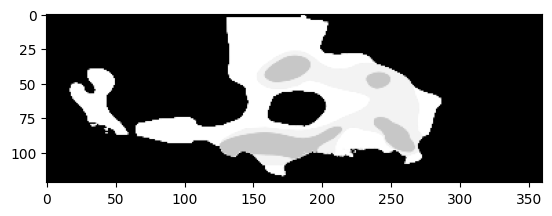

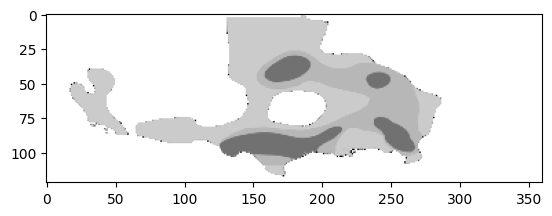

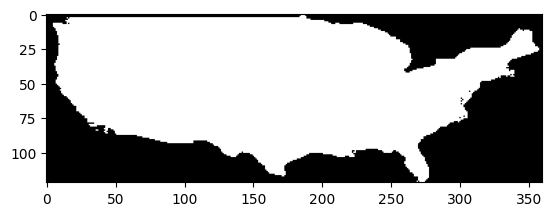

(122, 360) (122, 360)


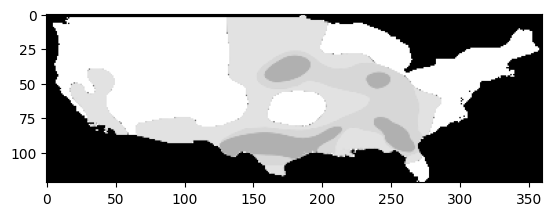

(1254, 122, 360)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import numpy as np
import pandas as pd
from pandas import DataFrame
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

import cv2

direccionImagenes = "/home/mccdual2080/Desktop/SahirReyes/Codigo/DroughtDataset"
direccionNombres = "DroughtDatasetMask/ActualizacionDataSetMani/NamesDroughtDataset.csv"
direccionImagenesMask = "DroughtDatasetMask/ActualizacionDataSetMani/imagenesMak1"

def get_names(file: str):
    names = DataFrame(pd.read_csv(file, header= None))
    #Get the first column
    return names[0]

def load_imgs(data_folder: str, names_file: str, rows: int, cols: int, channels= 1, img_type= '.png', color_mode= 'grayscale'):
    names = get_names(names_file)
    x = []
    for name in names:
        img = load_img('{}/{}'.format(data_folder, name), color_mode= color_mode, target_size= (rows, cols, channels))
        img = np.array(img)
        x.append(img)
    x = np.array(x)
    return x

def load_imgs_with_names(data_folder: str, names_file: str, rows: int, cols: int, invert= False, channels= 1, img_type= '.png', color_mode= 'grayscale'):
    names = names_file
    x = []
    for name in names:
        img = image.load_img('{}/{}'.format(data_folder, name), color_mode= color_mode, target_size= (rows, cols, channels))
        img = np.array(img)
        x.append(img)
    x = np.array(x)
    if invert:
        x = np.invert(x)
    return x

def to_monochromatic(img_data, min_val= 10, max_val= 255):
    x_mono = []
    for i in img_data:
        (thresh, monoImg) = cv2.threshold(i, min_val, max_val, cv2.THRESH_BINARY)
        x_mono.append(monoImg)
    x_mono = np.array(x_mono)
    return x_mono


def load_and_prepare_all_data(rows= 122, cols= 360, channels= 1):
    x = load_imgs(direccionImagenes, direccionNombres, 122, 360)
    x = x.astype('float32')
    x = x.reshape(len(x), rows, cols, channels)
    print('Data shape: {}'.format(x.shape))
    return x

x = load_and_prepare_all_data()

x = x.reshape(x.shape[0:-1])
#x = x.astype("int32")
print(x.shape)
print(x[0,0,0])
#print(x[1000].max())
res = np.zeros((x.shape[1],x.shape[2]), dtype=x.dtype)
#print(res)
#print(res.shape)


for i in x:
    res += i
#print(res)
result = np.where(res > 0, 1, 0)
result = result.astype("uint8")
print(result)

#x += 30

plt.imshow(x[0], cmap="gray")
plt.show()

new_x = np.where(x == 0, 255, x)

plt.imshow(new_x[0], cmap="gray")
plt.show()


plt.imshow(result, cmap="gray")
plt.show()

aux = new_x[0]

print(aux.shape, result.shape)

img = cv2.bitwise_and(aux, aux, mask= result)

plt.imshow(img, cmap="gray")
plt.show()

names = get_names(direccionNombres)
index = 0

new_array = np.array([])
for i in new_x:
    img_new = cv2.bitwise_and(i, i, mask= result)
    #img_new = img_new.reshape(img_new.shape[0], img_new.shape[1], 1)
    new_array = np.append(new_array, img_new)
    im = Image.fromarray(img_new)
    im = im.convert("RGB")
    im.save("{}/{}".format(direccionImagenesMask, names[index]))
    #im.save("DroughtDatasetMask/{}.png".format(names[index]))
    index += 1

new_array = new_array.reshape(x.shape)
print(new_array.shape)

np.save(direccionImagenesMask, new_array)

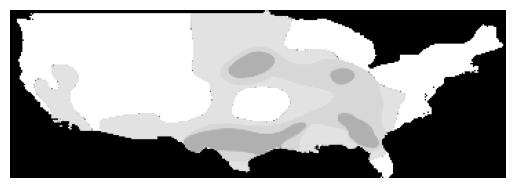

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy array
image_array = np.load("DroughtDatasetMask/ActualizacionDataSetMani/imagenesMak1.npy")

# Display the 1000th image
plt.imshow(image_array[0], cmap="gray")
plt.axis('off')
plt.show()
